# DPER

## Setup

In [1]:
from math import nan, isnan, inf, isfinite

import abc
import collections
import itertools
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import statistics
import sys

HOME = os.path.expanduser('~')

!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmExperiment

import util#.py

cerr = print

def getRunScript(slurmMemCap, strict):
    script = [
        '',
        f'#SBATCH --mem={slurmMemCap}g',
        f'#SBATCH --mail-type=end'
    ]
    script += [
        '',
        '#SBATCH --exclusive',
        '#SBATCH --constraint=ivybridge'
    ] if strict else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5'
    ]
    return '\n'.join(script)

In [2]:
DEPENDENCIES = [
    'dpmc.py',
    'wrapper.py',
    'postprocessor.py'
]

class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks', 'jointrees']:
            projectPath = f'/projects/anon/dper/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        netid = 'anon'
        return Inst(
            self,
            slurmqueen.ExperimentConfig(
                server=slurmqueen.SlurmServer('anon.edu', netid, f'{HOME}/.ssh/id_rsa'),
                partition='scavenge',
                local_directory=os.getcwd(),
                remote_directory=f'/scratch/{netid}/dper'
            )
        )

    @abc.abstractmethod
    def getWrapperDict(self, benchmarkPath):
        pass

    def getCmd(self, benchmarkPath):
        kwargs = {'cf': benchmarkPath, 'runner': 1}
        return Command(
            './wrapper.py',
            **kwargs,
            **self.getWrapperDict(benchmarkPath),
        ) | Command('./postprocessor.py')

    def getCmds(self):
        cmds = []
        filePaths = util.getFilePaths(self.benchmarkDir)
        for i in range(len(filePaths)):
            if not self.actualTasks or i in self.actualTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

def getIntDigits(num): # SlurmQueen
    return len(str(num))

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

In [3]:
class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def getTable(self, q):
        df = self.query(q)
        return df.rename(
            columns={col: col + self._exp.suffix for col in df.head() if col not in {'file', 'cf', 'base'}}
        )

    def runExp(self):
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local file ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTimeCap}')

    def checkData(self, allSat=True):
        def checkFile(filePath):
            if os.path.isfile(filePath):
                return True
            else:
                print(f'Missing file:\t{filePath}')
                return False

        benchmarkPaths = util.getFilePaths(self._exp.benchmarkDir)
        for i in range(len(benchmarkPaths)):
            checkFile(os.path.join(self._exp.id, f'slurm_{i}.worker'))
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{util.justifyInt(i, getIntDigits(len(benchmarkPaths)))}.{ext}'
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif allSat and os.path.basename(benchmarkPaths[i]) not in open(filePath).readline():
                        print(f'Wrong cf:\t{filePath}')

    def renameFiles(self):
        newDirPath = f'{self._exp.id}Renamed'
        os.makedirs(newDirPath)
        for i in range(len(self._exp.actualTasks)):
            newTask = self._exp.actualTasks[i]

            oldPath = os.path.join(self._exp.id, f'slurm_{i}.worker')
            newPath = os.path.join(newDirPath, f'slurm_{newTask}.worker')
            copyFile(oldPath, newPath)
            for ext in ['in', 'log', 'out']:
                oldDigits = getIntDigits(len(self._exp.actualTasks))
                newDigits = getIntDigits(len(util.getFilePaths(self._exp.benchmarkDir)))
                oldPath = os.path.join(self._exp.id, f'{util.justifyInt(i, oldDigits)}.{ext}')
                newPath = os.path.join(newDirPath, f'{util.justifyInt(newTask, newDigits)}.{ext}')
                try:
                    copyFile(oldPath, newPath)
                except FileNotFoundError as e:
                    print(e)

## Experiments

### DPMC

In [4]:
class DpmcExp(Exp):
    def __init__(
        self,
        ma,
        dp,
        decomposer,
        pw,
        suffix,
        benchmarkDir,
        dataDir,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.ma = ma
        self.dp = dp
        self.decomposer = decomposer
        self.pw = pw
        self.suffix = suffix
        self.benchmarkDir = benchmarkDir
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataDir,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dpmc',
            'ma': self.ma,
            'dp': self.dp,
            'decomposer': self.decomposer,
            'pw': self.pw,
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'pc': 1,
            'er': 1,
        }

#### WPMC benchmarks

In [5]:
HI_WPMC_DPMC_CUDD_FLOW_INST = DpmcExp(
    ma=1,
    dp='c',
    decomposer='flow',
    pw=0,
    suffix='DpCF',
    benchmarkDir='benchmarks/cnf/wpmc',
    dataDir='data/100g/wpmc/dpmc/cudd/flow',
    memCap=110,
    slurmMemCap=120,
    timeCap=1100,
    slurmTimeCap=1200,
).getInst()

HI_WPMC_DPMC_CUDD_FLOW_INST.checkData()

### erSSAT

In [6]:
class ErssatExp(Exp):
    def __init__(
        self,
        greedy,
        suffix,
        benchmarkDir,
        dataDir,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.greedy = greedy
        self.suffix = suffix
        self.benchmarkDir = benchmarkDir
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataDir,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'erssat',
            'extra': '' if self.greedy else '-g',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

#### WPMC benchmarks

In [7]:
HI_WPMC_ERSSAT_GREED_INST = ErssatExp(
    greedy=True,
    suffix='EGH',
    benchmarkDir='benchmarks/sdimacs/wpmc',
    dataDir='data/100g/wpmc/erssat/greed',
    memCap=110,
    slurmMemCap=120,
    timeCap=1100,
    slurmTimeCap=1200,
    actualTasks=[836]
).getInst()

HI_WPMC_ERSSAT_GREED_INST.checkData()

### DC-SSAT

In [8]:
class DcssatExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarkDir,
        dataDir,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarkDir = benchmarkDir
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataDir,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dcssat',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

#### WPMC benchmarks

In [9]:
HI_WPMC_DCSSAT_INST = DcssatExp(
    suffix = 'DcH',
    benchmarkDir='benchmarks/sdimacs/wpmc',
    dataDir='data/100g/wpmc/dcssat',
    memCap=110,
    slurmMemCap=120,
    timeCap=1100,
    slurmTimeCap=1200
).getInst()

HI_WPMC_DCSSAT_INST.checkData()

## Correctness

### WPMC benchmarks

In [10]:
q = 'select base, sol from data'

WPMC_CORR_TABLE = HI_WPMC_DCSSAT_INST.getTable(q)

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_ERSSAT_GREED_INST.getTable(q))

WPMC_CORR_TABLE

Reading all output data into SQL table
Reading all output data into SQL table
Reading all output data into SQL table


,base,solDcH,solDpCF,solEGH
0,01A-1.no_w,NaN,NaN,2.412742e-10
1,01B-1.no_w,NaN,NaN,NaN
2,01B-2.no_w,NaN,NaN,NaN
3,01B-3.no_w,NaN,NaN,NaN
4,01B-4.no_w,NaN,NaN,NaN
...,...,...,...,...
844,s9234a_3_2,NaN,NaN,0.000000e+00
845,s9234a_7_4,NaN,NaN,0.000000e+00
846,s953a_15_7,0.001082,0.001082,2.205372e-06
847,s953a_3_2,0.000957,0.000957,5.960464e-08


In [11]:
def getDiffTable(table, suffixes, floatDiff):
    diffRows = []
    for (_, row) in table.iterrows():
        sols = [row[f'sol{suffix}'] for suffix in suffixes]
        sols = list(itertools.filterfalse(isnan, sols))
        if sols:
            d = max(sols) - min(sols)
            if d > floatDiff:
                row['diff'] = d
                diffRows.append(row)
    return pd.DataFrame(diffRows)

getDiffTable(WPMC_CORR_TABLE, [
    'DcH',
    'DpCF',
    'EGH',
], 0)

,base,solDcH,solDpCF,solEGH,diff
14,03A-1.no_w,3.155360e-09,NaN,2.282531e-07,2.250977e-07
15,03A-2.no_w,6.232810e-10,NaN,1.761206e-06,1.760583e-06
68,10.sk_1_46.no_w,1.337420e-05,1.337420e-05,1.337585e-05,1.650000e-09
69,107.sk_3_90.no_w,2.300260e-09,NaN,1.972097e-08,1.742071e-08
70,109.sk_4_36.no_w,2.321900e-04,NaN,1.074955e-03,8.427650e-04
...,...,...,...,...,...
841,s838_3_2,1.950080e-07,1.950080e-07,0.000000e+00,1.950080e-07
842,s838_7_4,3.505560e-07,3.505560e-07,0.000000e+00,3.505560e-07
846,s953a_15_7,1.081900e-03,1.081900e-03,2.205372e-06,1.079695e-03
847,s953a_3_2,9.565240e-04,9.565240e-04,5.960464e-08,9.564644e-04


## Performance

### WPMC benchmarks

#### Tables

##### 100g

In [12]:
q = 'select base, sol, mem, time from data '

HI_WPMC_PERF_TABLE = HI_WPMC_DCSSAT_INST.getTable(q)

HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_ERSSAT_GREED_INST.getTable(q))

HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))

HI_WPMC_PERF_TABLE

,base,solDcH,memDcH,timeDcH,solEGH,memEGH,timeEGH,solDpCF,memDpCF,timeDpCF
0,01A-1.no_w,NaN,0.313240,1100.060000,2.412742e-10,0.024536,2.292390,NaN,0.075388,1100.0600
1,01B-1.no_w,NaN,0.367444,1100.040000,NaN,0.563200,1100.060000,NaN,0.311708,1100.0600
2,01B-2.no_w,NaN,0.650240,1100.050000,NaN,0.363036,1100.050000,NaN,0.582584,1100.0600
3,01B-3.no_w,NaN,0.935812,1100.070000,NaN,0.209348,1100.050000,NaN,0.889820,1100.0700
4,01B-4.no_w,NaN,1.221728,1100.050000,NaN,0.189900,1100.060000,NaN,1.199488,1100.0700
...,...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,36.058076,1101.950000,0.000000e+00,0.040844,3.246160,NaN,9.532296,1100.8500
845,s9234a_7_4,NaN,36.170800,1101.870000,0.000000e+00,0.036908,2.584620,NaN,24.757320,1102.3400
846,s953a_15_7,0.001082,0.027340,0.426929,2.205372e-06,0.000000,0.125196,0.001082,0.754956,144.0120
847,s953a_3_2,0.000957,0.021796,0.326709,5.960464e-08,0.000000,0.126902,0.000957,0.264680,15.2790


In [13]:
def getTime(row, suffix): # returns nan or finite num
    t = row[f'time{suffix}']
    assert isnan(t) or 0 < t < 2200, t
    return t

def isQualified(row, suffix, floatDiff, maxMem, maxTime): # allows sol underflow as maximizer is given
    time = getTime(row, suffix)
    if isnan(time) or time > maxTime:
        return False

    mem = row[f'mem{suffix}']
    if isnan(mem) or mem > maxMem:
        return False

    sol = row[f'sol{suffix}']
    if isnan(sol):
        return False
    try:
        ground = row[f'solDc']
    except KeyError:
        ground = row[f'solDcH']

    if isnan(ground):
        return True
    return abs(sol - ground) <= floatDiff

def getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime): # returns nan or finite num
    return getTime(row, suffix) if isQualified(row, suffix, floatDiff, maxMem, maxTime) else nan

def getTotalCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns int
    completions = 0
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                completions += 1
                break
    return completions

In [14]:
def getUniqueCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                if solver:
                    solver = ''
                    break
                else:
                    solver = suffix
        if solver:
            completions[solver] += 1
    return completions

getUniqueCompletions(HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
    'DpCF',
], 1e-6, 100, 1000)

Counter({'EGH': 170, 'DcH': 82, 'DpCF': 9})

In [15]:
def getFastestCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        time = inf
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                t = getTime(row, suffix)
                if t < time:
                    time = t
                    solver = suffix
                elif t == time:
                    solver = ''
        if solver:
            completions[solver] += 1
    return completions

getFastestCompletions(HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
    'DpCF',
], 1e-6, 100, 1000)

Counter({'EGH': 201, 'DcH': 221, 'DpCF': 62})

In [16]:
def getSolverTimes(table, suffix, floatDiff, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        times.append(getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime))
    return times

def getMeanPar2Score(times, maxTime, decimalPlaces=9):
    score = statistics.mean([time if isfinite(time) else maxTime * 2 for time in times])
    if decimalPlaces:
        score = util.truncateFloat(score, decimalPlaces)
    else:
        score = int(score)
    return score

def getSolverMeanPar2Scores(table, suffixes, floatDiff, maxMem, maxTime, decimalPlaces):
    return {
        suffix: getMeanPar2Score(
            getSolverTimes(table, suffix, floatDiff, maxMem, maxTime), maxTime, decimalPlaces
        ) for suffix in suffixes
    }

getSolverMeanPar2Scores(HI_WPMC_PERF_TABLE, 'DcH EGH DpCF'.split(), 1e-6, 100, 1000, 0)

{'DcH': 1335, 'EGH': 1392, 'DpCF': 1522}

In [17]:
def getVbsTimes(table, suffixes, floatDiff, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        time = inf
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                time = min(time, getTime(row, suffix))
        times.append(time if isfinite(time) else nan)
    return times

def getVbsMeanPar2Scores(table, suffixTuples, floatDiff, maxMem, maxTime, decimalPlaces):
    return {
        suffixTuple: getMeanPar2Score(
            getVbsTimes(table, suffixTuple, floatDiff, maxMem, maxTime), maxTime, decimalPlaces
        )
        for suffixTuple in suffixTuples
    }

getVbsMeanPar2Scores(HI_WPMC_PERF_TABLE, [
    (
        'DcH',
        'EGH'
    ),
    (
        'DcH',
        'EGH',
        'DpCF',
    )
], 1e-6, 100, 1000, 0)

{('DcH', 'EGH'): 912, ('DcH', 'EGH', 'DpCF'): 888}

#### Figures

In [18]:
plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 9,
    'text.usetex': True # type-1 font
})

def getFigAx(heightByWidth):
    def getFigSize(heightByWidth):
        figWidthPt = 398.33858 # CP22 \the\textwidth
        figWidthPt *= 1.1 # still fits
        figWidthIn = figWidthPt / 72.27
        figHeightIn = heightByWidth * figWidthIn
        return (figWidthIn, figHeightIn)

    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    ax.grid(True)
    return (fig, ax)

def saveFig(fig, filePath):
    filePath = os.path.expanduser(filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def drawCurve(ax, timeList, label, style):
    def getTimesAndCompletions(timeList): # returns (times, completions)
        timeList = sorted(timeList)
        times = timeList[:1]
        completions = [1]
        for t in timeList[1:]:
            if t == times[-1]:
                completions[-1] += 1
            else:
                times.append(t)
                completions.append(1 + completions[-1])
        return (times, completions)

    ax.plot(*getTimesAndCompletions(timeList), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Longest solving time (seconds)')
    ax.set_ylabel('Total solved benchmarks')

def drawSolverCurve(ax, table, suffix, floatDiff, maxMem, maxTime, label, style):
    drawCurve(ax, filter(isfinite, getSolverTimes(table, suffix, floatDiff, maxMem, maxTime)), label, style)

def drawVbsCurve(ax, table, suffixes, floatDiff, maxMem, maxTime, label, style):
    drawCurve(ax, filter(isfinite, getVbsTimes(table, suffixes, floatDiff, maxMem, maxTime)), label, style)

##### 100g

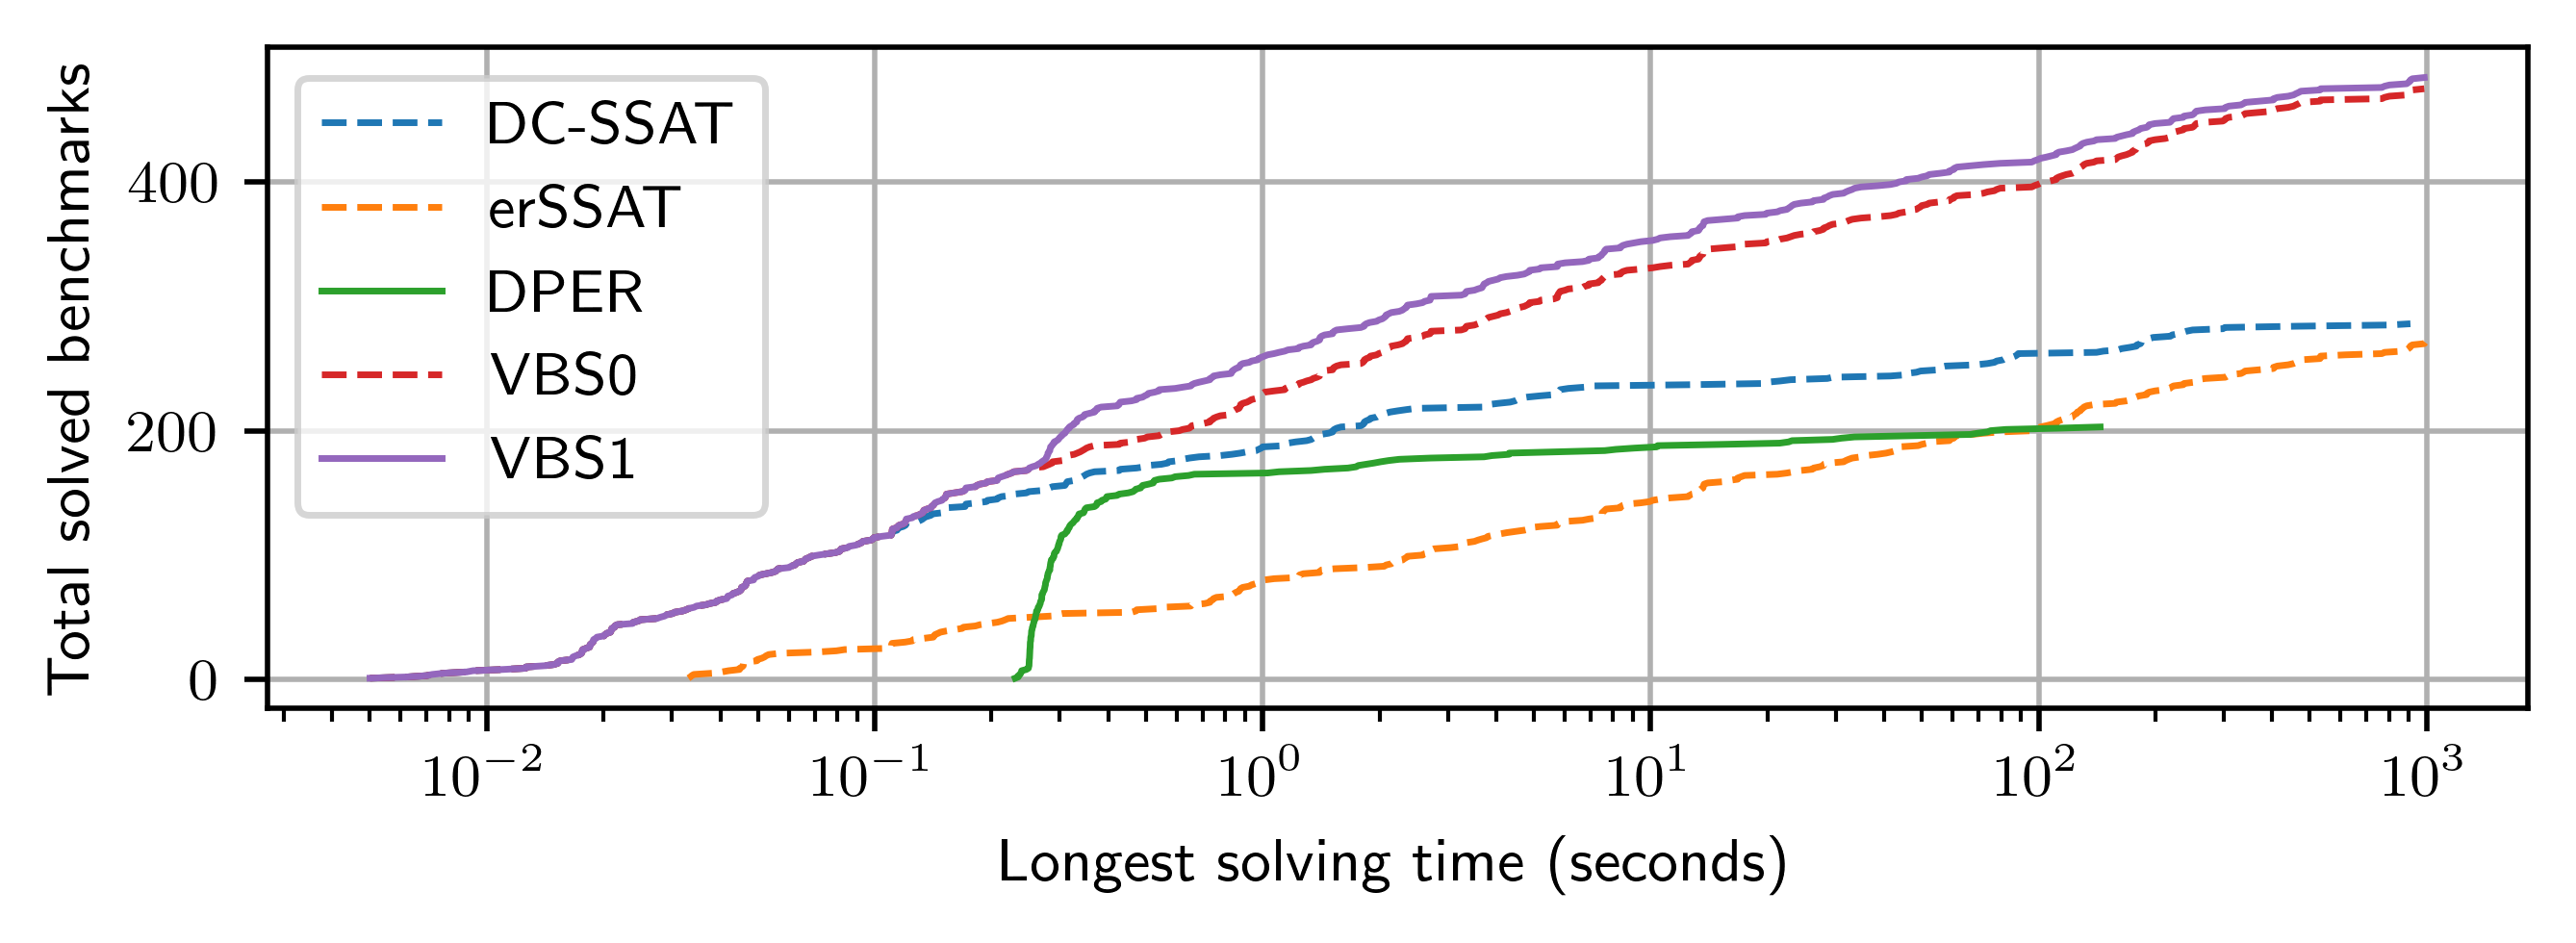

In [19]:
(fig, ax) = getFigAx(.3)

d = 1e-6
m = 100
t = 1000

drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DcH', d, m, t, 'DC-SSAT', '--')
drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'EGH', d, m, t, 'erSSAT', '--')
drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DpCF', d, m, t, 'DPER', '-')

drawVbsCurve(ax, HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH'
], d, m, t, 'VBS0', '--')
drawVbsCurve(ax, HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
    'DpCF',
], d, m, t, 'VBS1', '-')

# saveFig(fig, '~/code/cp22/figures/solvers.pgf')

In [20]:
WIDTH_TABLE = HI_WPMC_DPMC_CUDD_FLOW_INST.query(
    'select base, width1 from data where width is not null '
    'and treetime1 < 1000 '
    'order by width'
)

WIDTH_TABLE = WIDTH_TABLE.merge(HI_WPMC_PERF_TABLE)

WIDTH_TABLE

,base,width1,solDcH,memDcH,timeDcH,solEGH,memEGH,timeEGH,solDpCF,memDpCF,timeDpCF
0,tableBasedAddition.sk_240_1024.no_w,1.0,4.177720e-299,0.000000,0.021385,4.177724e-299,0.000000,0.051129,4.177720e-299,0.038712,0.284954
1,tutorial1.sk_1_1.no_w,1.0,4.000000e-01,0.000000,0.014900,4.000000e-01,0.000000,0.038239,4.000000e-01,0.037992,0.258701
2,s27_15_7.no_w,4.0,9.216000e-02,0.000000,0.011015,9.215999e-02,0.000000,0.051954,9.216000e-02,0.034404,0.263142
3,s27_3_2.no_w,4.0,1.296000e-01,0.000000,0.018782,1.296000e-01,0.000000,0.045468,1.296000e-01,0.035572,0.267815
4,s27_7_4.no_w,4.0,1.209600e-01,0.000000,0.018472,1.209600e-01,0.000000,0.044822,1.209600e-01,0.048352,0.301696
...,...,...,...,...,...,...,...,...,...,...,...
236,s9234a_15_7.no_w,98.0,NaN,36.106240,1101.830000,0.000000e+00,0.042812,2.710500,NaN,2.051664,1100.070000
237,s9234a_15_7,98.0,NaN,35.486324,1102.070000,0.000000e+00,0.044316,2.714870,NaN,17.025144,1101.250000
238,min-4.no_w,100.0,NaN,2.237768,1100.110000,0.000000e+00,0.030736,0.829245,NaN,2.017256,1100.070000
239,s953a_15_7.no_w,100.0,2.437440e-05,0.028924,0.472984,3.218651e-06,0.018552,0.199996,2.437440e-05,0.517424,75.144100


In [21]:
def getTimesByWidthBySolver(table, suffixes, floatDiff, maxMem, maxTime): # return solver |-> (width |-> times)
    mapping = collections.defaultdict(dict)
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            w = int(row['width1'])
            t = getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime)
            if w in mapping[suffix]:
                mapping[suffix][w].append(t)
            else:
                mapping[suffix][w] = [t]
    return mapping

SUFFIXES = ['DcH', 'EGH', 'DpCF']

# getTimesByWidthBySolver(WIDTH_TABLE, SUFFIXES, 1e-6, maxMem=100, maxTime=1000)

In [22]:
def getTimesByWidthsBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # return solver |-> (widths |-> times)
    mapping = collections.defaultdict(dict)
    for (solver, timesByWidth) in getTimesByWidthBySolver(table, suffixes, floatDiff, maxMem, maxTime).items():
        timesByWidth = sorted(timesByWidth.items())
        for i in range(len(timesByWidth) - widthCount + 1):
            ws = ()
            ts = []
            for (width, times) in timesByWidth[i : i + widthCount]:
                ws += width,
                ts.extend(times)
            mapping[solver][ws] = ts
    return mapping

# getTimesByWidthsBySolver(WIDTH_TABLE, SUFFIXES, 1e-6, maxMem=100, maxTime=1000, widthCount=2)

In [23]:
def getMeanPar2ScoreByWidthsBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # returns solver |-> (widths |-> score)
    mapping = collections.defaultdict(dict)
    timesByWidthsBySolver = getTimesByWidthsBySolver(table, suffixes, floatDiff, maxMem, maxTime, widthCount)
    for (suffix, timesByWidths) in timesByWidthsBySolver.items():
        for (widths, times) in timesByWidths.items():
            mapping[suffix][widths] = getMeanPar2Score(times, maxTime)
    return mapping

# getMeanPar2ScoreByWidthsBySolver(WIDTH_TABLE, SUFFIXES, 1e-6, 100, 1000, widthCount=2)

In [24]:
def getMeanPar2ScoreByMeanWidthBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # returns solver |-> (width |-> score)
    mapping = {}
    for (solver, scoreByWidths) in getMeanPar2ScoreByWidthsBySolver(
        table, suffixes, floatDiff, maxMem, maxTime, widthCount
    ).items():
        mapping[solver] = {statistics.mean(widths): score for (widths, score) in scoreByWidths.items()}
    return mapping

# getMeanPar2ScoreByMeanWidthBySolver(WIDTH_TABLE, SUFFIXES, 1e-6, 100, 1000, widthCount=2)

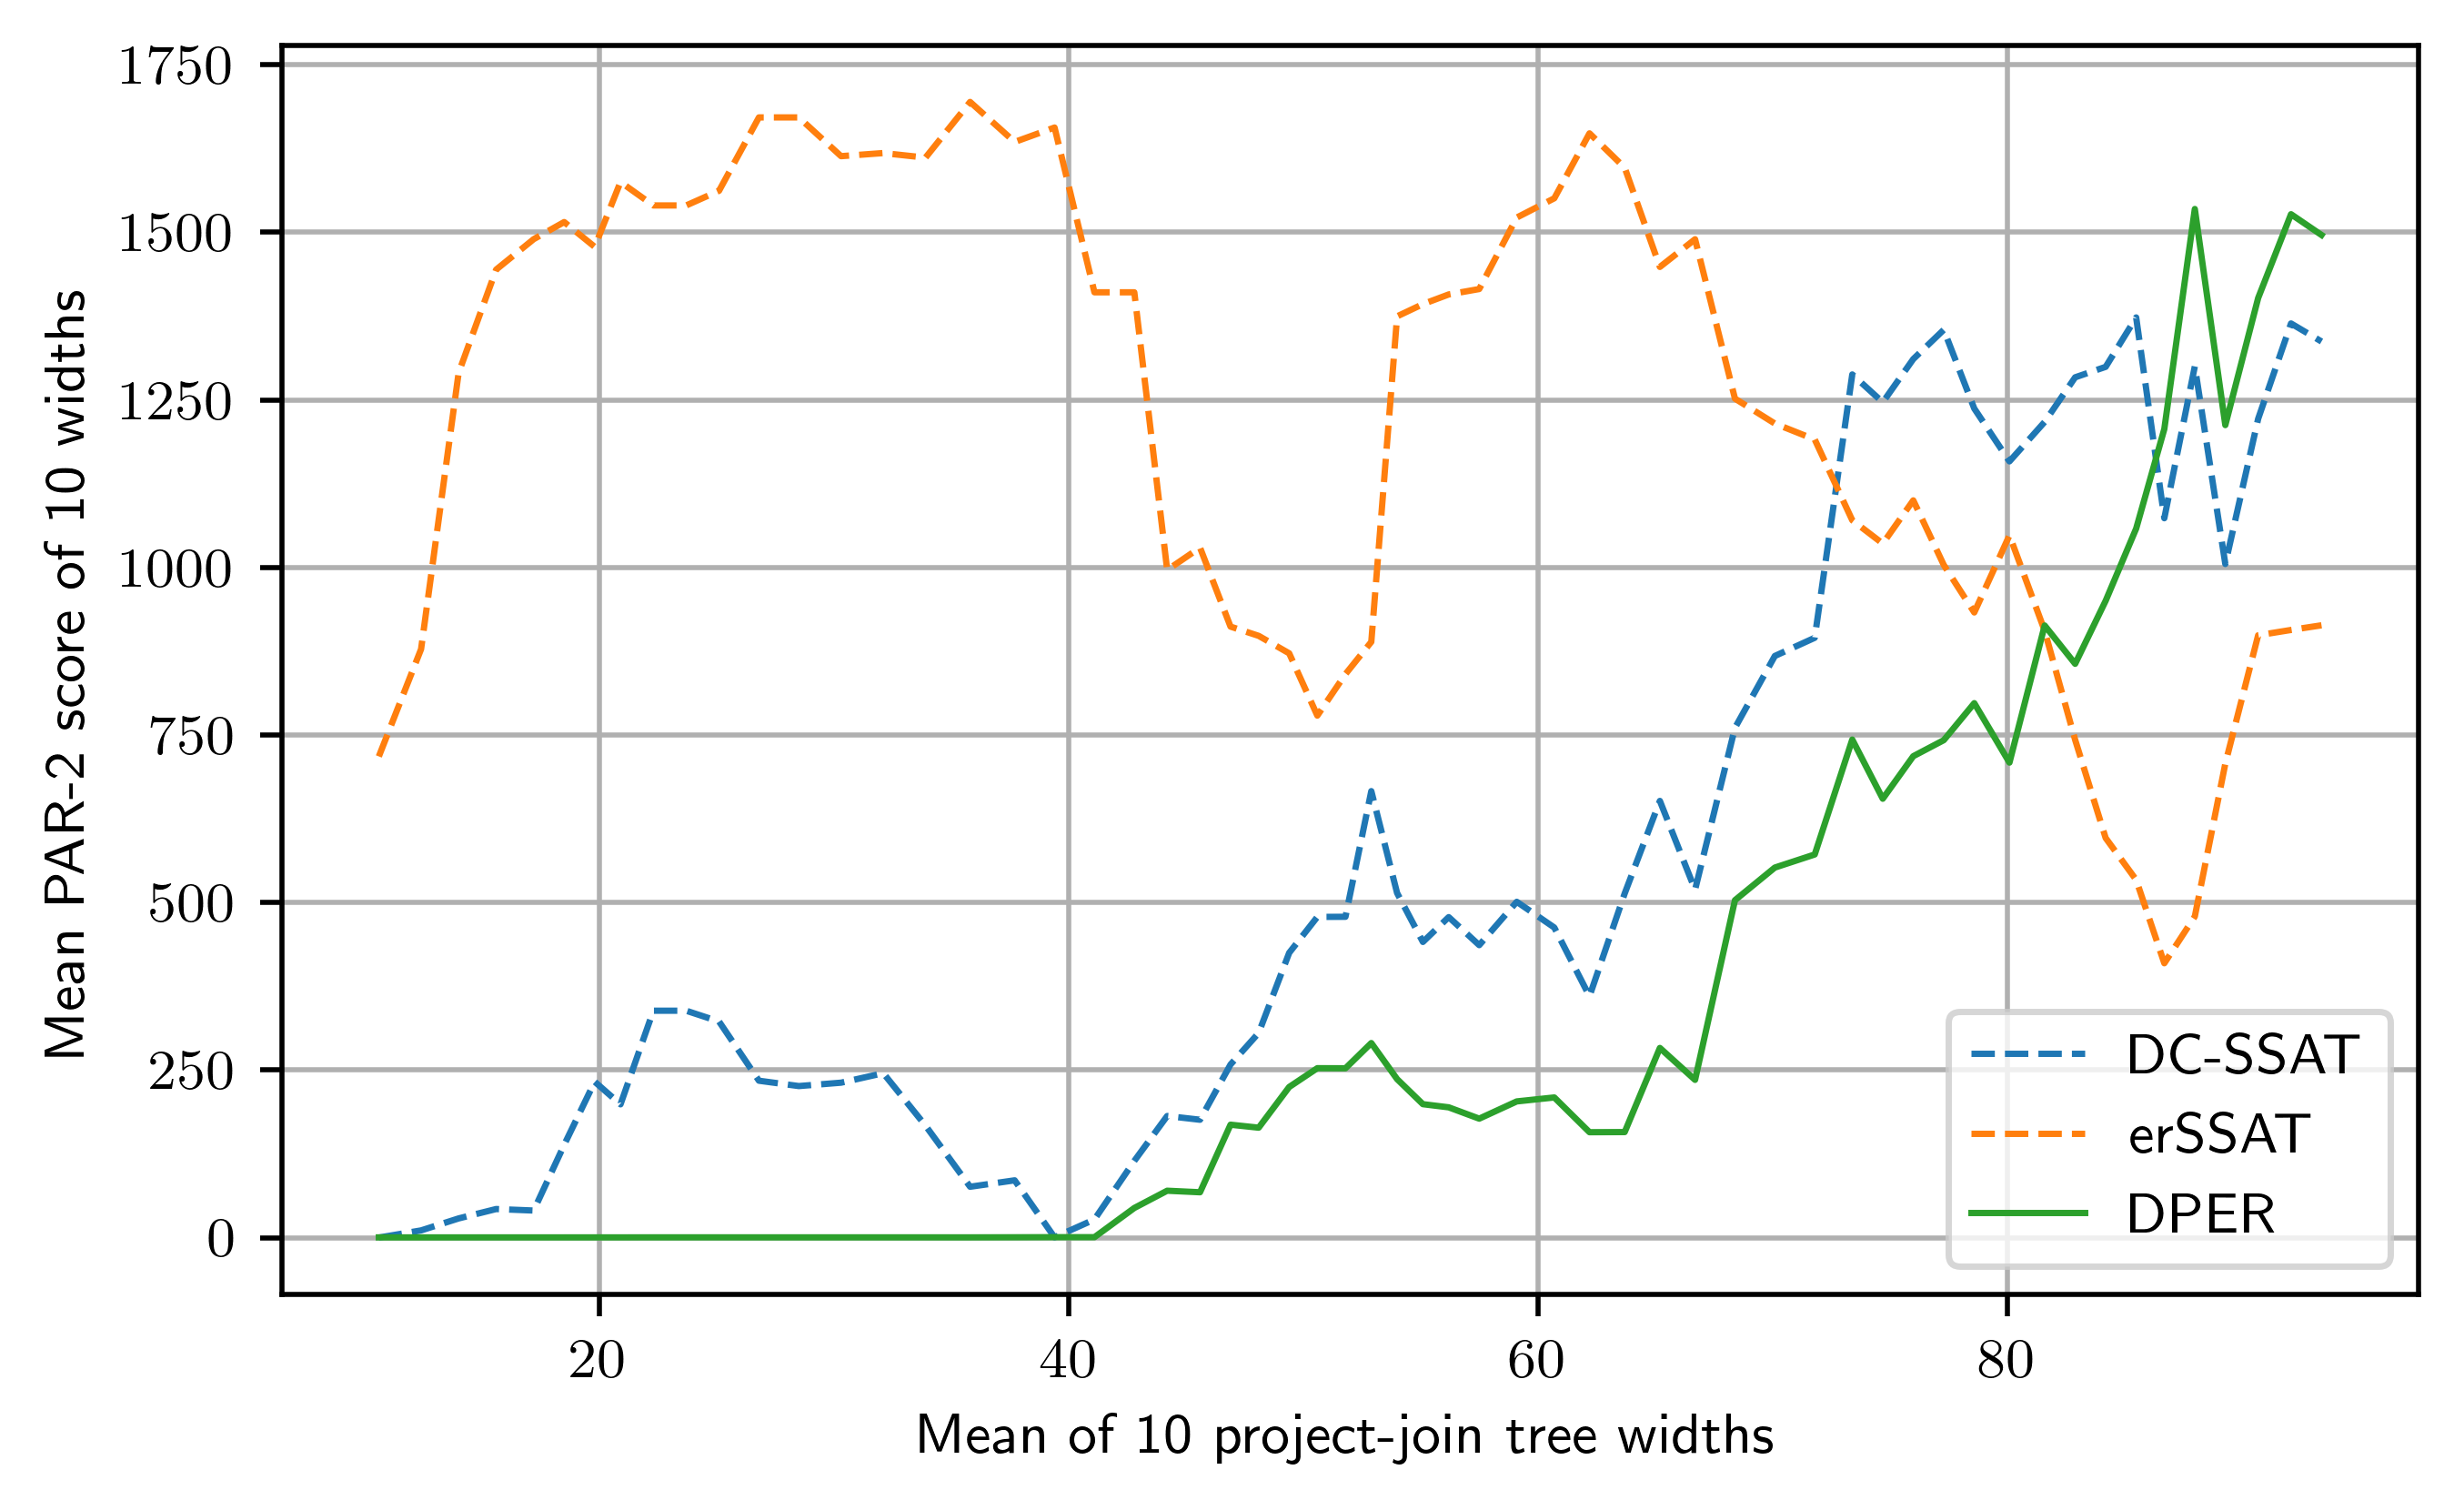

In [25]:
def drawWidthCurve(ax, table, suffixes, floatDiff, maxMem, maxTime, widthCount, suffix, label, style):
    m = getMeanPar2ScoreByMeanWidthBySolver(table, suffixes, floatDiff, maxMem, maxTime, widthCount)[suffix]
    ax.plot(m.keys(), m.values(), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xlabel(f'Mean of {widthCount} project-join tree widths')
    ax.set_ylabel(f'Mean PAR-2 score of {widthCount} widths')

(fig, ax) = getFigAx(.6)
d = 1e-6
m = 100
t = 1000
w = 10

drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DcH', 'DC-SSAT', '--')
drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'EGH', 'erSSAT', '--')
drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DpCF', 'DPER', '-')

# saveFig(fig, '~/code/cp22/figures/widths.pgf')